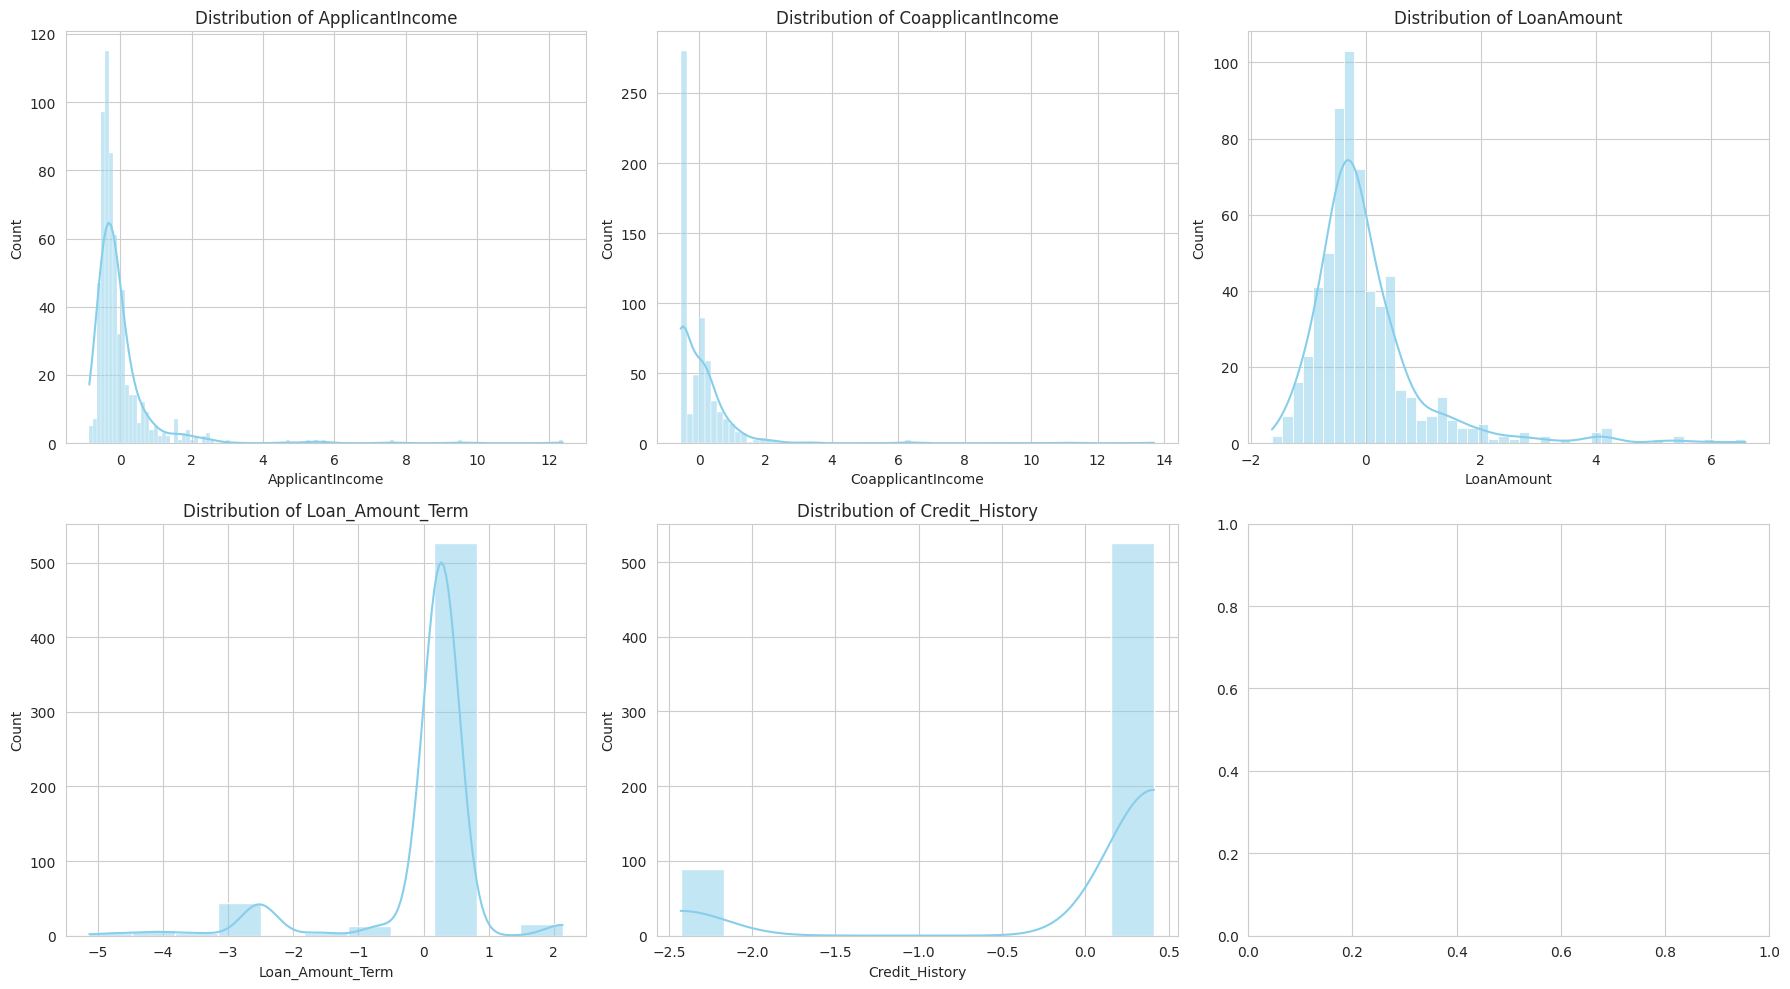

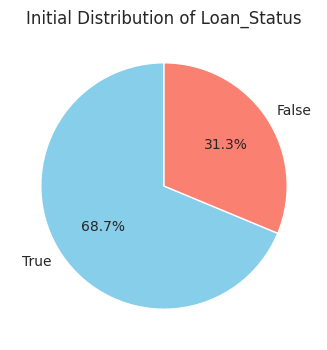

Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Best parameters for Random Forest: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
Best parameters for SVM: {'C': 10, 'gamma': 'scale'}
Best parameters for KNN: {'n_neighbors': 9, 'weights': 'distance'}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 100}
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best parameters for MLP Classifier: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Results for Logistic Regression:
Confusion Matrix:
 [[117  19]
 [  6 112]]
Accuracy: 0.9015748031496063
F1 Score: 0.8995983935742973
Recall: 0.9491525423728814
Precision: 0.8549618320610687
ROC AUC: 0.9261590229312064


Results for Decision Tree:
Confusion M

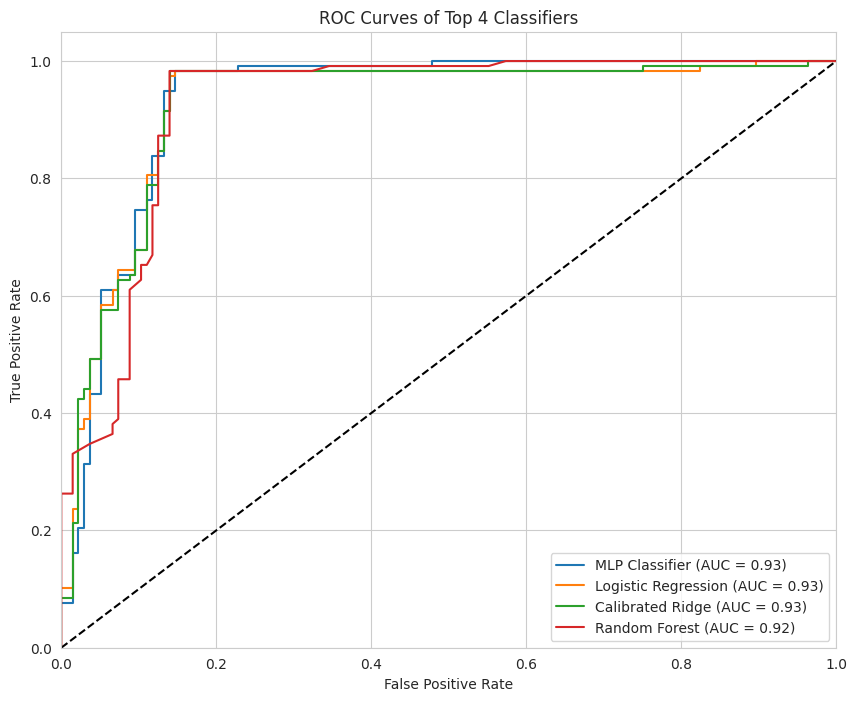

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/content/loan-train.csv'
data = pd.read_csv(file_path)

# Function to fill missing values, encode categorical variables, and scale data
def preprocess_data(df):
    # Fill missing values
    for column in df.columns:
        if df[column].dtype == 'object':  # Categorical data
            df[column].fillna(df[column].mode()[0], inplace=True)
        else:  # Numerical data
            df[column].fillna(df[column].median(), inplace=True)

    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Encode categorical variables
    df = pd.get_dummies(df, drop_first=True)

    return df

data = preprocess_data(data)

# Visualizations
sns.set_style("whitegrid")

# Histograms for numerical columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
num_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

for i, col in enumerate(num_columns):
    if col in data.columns:
        sns.histplot(data[col], kde=True, ax=axes[i//3, i%3], color='skyblue').set_title(f'Distribution of {col}')

plt.tight_layout()

# Visualizing the distribution of Loan_Status
loan_status_counts = data['Loan_Status_Y'].value_counts()  # Adjusted for one-hot encoding
plt.figure(figsize=(8, 4))
loan_status_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Initial Distribution of Loan_Status')
plt.ylabel('')
plt.show()

# Separate features and target variable
X = data.drop('Loan_Status_Y', axis=1)
y = data['Loan_Status_Y']

# Balancing the dataset by oversampling the minority class
max_size = y.value_counts().max()
lst = [data]
for class_index, group in data.groupby('Loan_Status_Y'):
    lst.append(group.sample(max_size-len(group), replace=True))
data_balanced = pd.concat(lst)

X = data_balanced.drop('Loan_Status_Y', axis=1)
y = data_balanced['Loan_Status_Y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Calibrated Ridge": CalibratedClassifierCV(RidgeClassifier(), method='sigmoid', cv=5),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "MLP Classifier": MLPClassifier(max_iter=300)
}

# Define parameter grids for each classifier
param_grids = {
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']},
    "Decision Tree": {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    "Random Forest": {'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 10, 20]},
    "SVM": {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    "KNN": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7]},
    "AdaBoost": {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
    "Calibrated Ridge": {},  # No tuning for calibrated model; parameters are for the base model
    "XGBoost": {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]},
    "MLP Classifier": {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam']}
}

# Apply hyperparameter tuning for each classifier
for name, clf in classifiers.items():
    if param_grids[name]:  # Check if there are parameters to tune
        grid_search = GridSearchCV(clf, param_grids[name], cv=3, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        classifiers[name] = grid_search.best_estimator_  # Use the best model found by GridSearchCV
        print(f"Best parameters for {name}: {grid_search.best_params_}")

# Training and evaluating classifiers with tuned parameters
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    if y_probas is not None:
        fpr, tpr, _ = roc_curve(y_test, y_probas)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            "Confusion Matrix": confusion_matrix(y_test, y_pred),
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "ROC AUC": roc_auc,
            "FPR": fpr,
            "TPR": tpr
        }
    else:
        results[name] = {
            "Confusion Matrix": confusion_matrix(y_test, y_pred),
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "ROC AUC": 'N/A'
        }

# Print the results for each classifier
for name, metrics in results.items():
    print(f"Results for {name}:")
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Accuracy:", metrics["Accuracy"])
    print("F1 Score:", metrics["F1 Score"])
    print("Recall:", metrics["Recall"])
    print("Precision:", metrics["Precision"])
    print("ROC AUC:", metrics.get("ROC AUC", 'N/A'))
    print("\n")

# Find the top 4 classifiers based on ROC AUC
top_4_classifiers = sorted(results.items(), key=lambda x: x[1]["ROC AUC"], reverse=True)[:4]

# Plot ROC curves for the top 4 classifiers
plt.figure(figsize=(10, 8))
for name, metrics in top_4_classifiers:
    plt.plot(metrics["FPR"], metrics["TPR"], label=f'{name} (AUC = {metrics["ROC AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Top 4 Classifiers')
plt.legend(loc='lower right')
plt.show()
